## Containerization

Using containerization technologies to package research code and its dependencies into a self-contained environment is useful for ensuring that others can run the code with the same software setup.

Specifically, we'll talk about containerization with [Docker](https://www.docker.com/) as it is a commonly used tool with wide adoption in industry for developing and publishing reproducible workflows. Let's further explore and show an example implementattion of containerization for a geospatial study.

**Understanding Docker**:

Docker is a platform designed to make it easier to create, deploy, and run applications by using [containers](https://www.docker.com/resources/what-container/). Containers allow developers to package an application with all of the parts it needs, such as libraries and other dependencies, and ship it all out as one package. This ensures that the application will run reliably on any computing environment, regardless of the differences between development and staging environments, or between production environments and individual developer laptops.

Some more key features of Docker:

1. **Standardization**: Docker provides a standardized way to package and distribute applications, along with all their dependencies, as lightweight containers. This standardization ensures that applications behave consistently across different environments, from development to production.

2. **Isolation**: Docker containers provide process isolation, meaning each container runs as an isolated process on the host system. This isolation ensures that applications running in one container do not interfere with applications running in other containers, even if they share the same host operating system.

3. **Portability**: Docker containers are portable and can run on any system that supports Docker, regardless of the underlying infrastructure. This portability enables developers to build once and deploy anywhere, reducing the risk of compatibility issues and making it easier to migrate applications between different environments.

4. **Efficiency**: Docker containers are lightweight and have minimal overhead compared to traditional virtual machines. They share the host system's kernel and only include the application code and dependencies required to run the application. This efficiency results in faster startup times, lower memory usage, and better resource utilization.

5. **Scalability**: Docker makes it easy to scale applications horizontally by running multiple instances of the same container across different hosts or clusters. Container orchestration tools like [Kubernetes](https://kubernetes.io/) further automate the deployment, scaling, and management of containerized applications, making it easier to scale applications to meet changing demands.


**Creating Docker Images**:

Write a Dockerfile, which is a text file that contains instructions for building a Docker image. Usually, it contains info on a [base image](https://docs.docker.com/build/building/base-images/) that provides the operating system and runtime environment for your application to use, any dependencies to install, environment variables to set, and commands to run when the container starts. Dependencies are usually set to be installed in the Dockerfile using package managers like apt, pip, or conda. This is dependent on the oeprating system and dependencies themselves. Lastly, in terms of bare minimum requirements of Dockerfile constituents, you would supply the steps to run your research code, scripts, and configuration files. An example of this would be calling a python script.

It's important to ensure that all dependencies required by your code are explicitly listed and installed within the Docker image. Often, it might be useful to pin dependency versions to specific releases or versions to maintain reproducibility and avoid unexpected behavior due to updates.

**Version Control and Documentation**:

Maintaining proper version control of your Dockerfile and associated scripts using a version control system like Git is crucial to making sure users of the code are aware of the latest or most stable implementation. Similarly, documenting the steps for building and running the Docker image in your project's README file or documentation and including information about how to pull, build, and run the Docker image on different platforms or environments is also very important for easy adoption.


### Example workflow

Let's walk through a very simple workflow of building a docker image that is tasked to run a python script which runs a [K-Means](https://www.kdnuggets.com/2019/08/introduction-image-segmentation-k-means-clustering.html#:~:text=K%2DMeans%20clustering%20algorithm%20is,based%20on%20the%20K%2Dcentroids.) image segmentation of Sentinel-2 NDVI for the same area as that which we introduced in the chapter on "Open Access to Data and Code."

/Users/lillythomas/.pyenv/versions/3.9.0/envs/py39b/lib/python3.9/site-packages/pystac_client/item_search.py:841: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Found 4 items


/Users/lillythomas/.pyenv/versions/3.9.0/envs/py39b/lib/python3.9/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


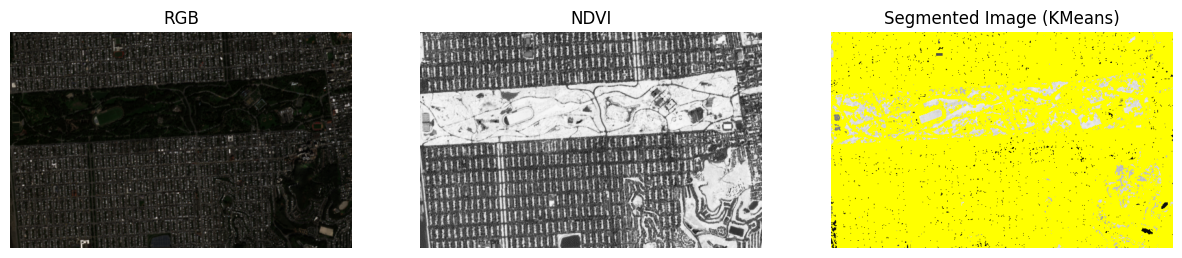

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
import pystac_client
import stackstac
from datetime import datetime, timedelta
import xarray as xr
from rasterio.enums import Resampling
from sklearn.cluster import KMeans
from skimage.segmentation import mark_boundaries

def fetch_sentinel_image(stac_url: str, collection: str, bbox: list, start_date: datetime, end_date: datetime, bands: list, max_cloud_cover: int, epsg: int) -> xr.DataArray:
    """
    Fetches Sentinel-2 image data from a specified STAC catalog.

    Parameters:
        stac_url (str): URL of the STAC catalog.
        collection (str): Name of the collection to search within the STAC catalog.
        bbox (list): Bounding box coordinates [minx, miny, maxx, maxy].
        start_date (datetime): Start date of the time range to search for images.
        end_date (datetime): End date of the time range to search for images.
        bands (list): List of bands to fetch from Sentinel-2 data.
        max_cloud_cover (int): Maximum cloud cover percentage allowed for images.
        epsg (int): EPSG code for the desired coordinate reference system.

    Returns:
        xr.DataArray: Xarray DataArray containing the fetched Sentinel-2 image data.
    """
    catalog = pystac_client.Client.open(stac_url)

    area_of_interest = box(*bbox)

    search = catalog.search(
        collections=[collection],
        datetime=(start_date, end_date),
        intersects=area_of_interest,
        max_items=100,
        query={"eo:cloud_cover": {"lt": max_cloud_cover}},
    )

    items = search.get_all_items()

    print(f"Found {len(items)} items")

    if len(items) == 0:
        raise ValueError("No items found in the given time range and bounding box.")

    item = items[-1]
    stack = stackstac.stack(
        item,
        bounds=bbox,
        snap_bounds=False,
        dtype="float32",
        epsg=epsg,
        rescale=False,
        fill_value=0,
        assets=bands,
        resampling=Resampling.nearest,
        xy_coords="center",
    )

    stack = stack.compute() 
    return stack

def calculate_ndvi(image_data):
    """
    Calculates Normalized Difference Vegetation Index (NDVI) from Sentinel-2 image data.

    Parameters:
        image_data (xr.DataArray): Xarray DataArray containing Sentinel-2 image data.

    Returns:
        xr.DataArray: Xarray DataArray containing the computed NDVI values.
    """
    nir_band = image_data.sel(band="nir")
    red_band = image_data.sel(band="red")
    
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    
    return ndvi

# Example usage:
STAC_URL = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"
BBOX = [-122.51, 37.75, -122.45, 37.78]
START_DATE = datetime.utcnow() - timedelta(weeks=4)
END_DATE = datetime.utcnow()
MAX_CLOUD_COVER = 80
BANDS = ["red", "green", "blue", "nir"]
EPSG = 4326

image_data = fetch_sentinel_image(STAC_URL, COLLECTION, BBOX, START_DATE, END_DATE, BANDS, MAX_CLOUD_COVER, EPSG)
ndvi = calculate_ndvi(image_data)

ndvi_flat = ndvi.values.flatten().reshape(-1, 1)

kmeans = KMeans(n_clusters=10, random_state=0).fit(ndvi_flat)
cluster_labels = kmeans.labels_.reshape(ndvi.shape)

ndvi_display = np.array(ndvi).transpose(1, 2, 0)
cluster_labels_display = cluster_labels.astype(int).transpose(1, 2, 0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

rgb_image = np.stack([image_data.sel(band=band).values for band in ['red', 'green', 'blue']], axis=-1)
rgb_min = np.min(rgb_image)
rgb_max = np.max(rgb_image)
scaled_rgb_image = ((rgb_image - rgb_min) / (rgb_max - rgb_min)) * 255
scaled_rgb_image_uint8 = scaled_rgb_image.astype(np.uint8)

axes[0].imshow(scaled_rgb_image_uint8.squeeze())
axes[0].set_title('RGB')
axes[0].axis('off')

axes[1].imshow(ndvi_display.squeeze(), cmap='Greys_r')
axes[1].set_title('NDVI')
axes[1].axis('off')

axes[2].imshow(mark_boundaries(ndvi_display.squeeze(), cluster_labels_display.squeeze()))
axes[2].set_title('Segmented Image (KMeans)')
axes[2].axis('off')

plt.show()



### Build the docker image

Once you've [installed Docker](https://docs.docker.com/get-docker/), you'll be able to create a docker image by following these steps.

1. Name the scipt (e.g. `s2_ndvi_kmeans.py`)
2. Write a docker file that will set up the environment, install dependencies and run the scipt
3. Build the docker image
4. Run a container from the built image

Write a docker file in your IDE:

```
# Use an official Python runtime as a parent image
FROM python:3.8

# Set the working directory in the container
WORKDIR /app

# Copy the current directory contents into the container at /app
COPY . /app

# Install any needed dependencies specified in requirements.txt
RUN pip install numpy matplotlib shapely pystac-client stackstac xarray scikit-image

# Run the script when the container launches
CMD ["python", "s2_ndvi_kmeans.py"]
```

Build the docker image from your CLI:

```
docker build -t s2_ndvi_kmeans .
```

Run a container from the built image via your CLI:

```
docker run -it --rm s2_ndvi_kmeans
```

You should see the script execute and output traceback to your terminal.